In [1]:

import sys
gems_tco_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/src/"
sys.path.append(gems_tco_path)

import copy
import sys
import logging
import argparse # Argument parsing
import math
from collections import defaultdict
import concurrent
from concurrent.futures import ThreadPoolExecutor  # Importing specific executor for clarity
import time

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Nearest neighbor search
import sklearn
from sklearn.neighbors import BallTree

# Special functions and optimizations
from scipy.special import gamma, kv  # Bessel function and gamma function
from scipy.stats import multivariate_normal  # Simulation
from scipy.optimize import minimize
from scipy.spatial.distance import cdist  # For space and time distance
from scipy.spatial import distance  # Find closest spatial point
from scipy.optimize import differential_evolution

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Type hints
from typing import Callable, Union, Tuple

# Add your custom path
# sys.path.append("/cache/home/jl2815/tco")

# Custom imports
from GEMS_TCO import orbitmap 
from GEMS_TCO import kernels 
from GEMS_TCO import evaluate

import pickle
import torch
import torch.optim as optim

from GEMS_TCO import orderings as _orderings

In [5]:
lat_lon_resolution = [10,10]
mm_cond_number = 10
params= [20, 8.25, 5.25, 0.2, 0.5, 5]

# Load the one dictionary to set spaital coordinates
# filepath = "C:/Users/joonw/TCO/GEMS_data/data_2023/sparse_cen_map23_01.pkl"
filepath = "/Users/joonwonlee/Documents/GEMS_DATA/pickle_2023/coarse_cen_map23_01.pkl"
with open(filepath, 'rb') as pickle_file:
    coarse_dict_24_1 = pickle.load(pickle_file)

sample_df = coarse_dict_24_1['y23m01day01_hm02:12']

sample_key = coarse_dict_24_1.get('y23m01day01_hm02:12')
if sample_key is None:
    print("Key 'y23m01day01_hm02:12' not found in the dictionary.")

# { (20,20):(5,1), (5,5):(20,40) }
rho_lat = lat_lon_resolution[0]          
rho_lon = lat_lon_resolution[1]
lat_n = sample_df['Latitude'].unique()[::rho_lat]
lon_n = sample_df['Longitude'].unique()[::rho_lon]

lat_number = len(lat_n)
lon_number = len(lon_n)

# Set spatial coordinates for each dataset
coarse_dicts = {}

years = ['2024']
for year in years:
    for month in range(7, 8):  # Iterate over all months
        # filepath = f"C:/Users/joonw/TCO/GEMS_data/data_{year}/sparse_cen_map{year[2:]}_{month:02d}.pkl"
        filepath = f"/Users/joonwonlee/Documents/GEMS_DATA/pickle_{year}/coarse_cen_map{year[2:]}_{month:02d}.pkl"
        with open(filepath, 'rb') as pickle_file:
            loaded_map = pickle.load(pickle_file)
            for key in loaded_map:
                tmp_df = loaded_map[key]
                coarse_filter = (tmp_df['Latitude'].isin(lat_n)) & (tmp_df['Longitude'].isin(lon_n))
                coarse_dicts[f"{year}_{month:02d}_{key}"] = tmp_df[coarse_filter].reset_index(drop=True)


key_idx = sorted(coarse_dicts)
if not key_idx:
    raise ValueError("coarse_dicts is empty")

# extract first hour data because all data shares the same spatial grid
data_for_coord = coarse_dicts[key_idx[0]]
x1 = data_for_coord['Longitude'].values
y1 = data_for_coord['Latitude'].values 
coords1 = np.stack((x1, y1), axis=-1)


# instance = orbitmap.MakeOrbitdata(data_for_coord, lat_s=5, lat_e=10, lon_s=110, lon_e=120)
# s_dist = cdist(coords1, coords1, 'euclidean')
# ord_mm, _ = instance.maxmin_naive(s_dist, 0)

ord_mm = _orderings.maxmin_cpp(coords1)
data_for_coord = data_for_coord.iloc[ord_mm].reset_index(drop=True)
coords1_reordered = np.stack((data_for_coord['Longitude'].values, data_for_coord['Latitude'].values), axis=-1)
# nns_map = instance.find_nns_naive(locs=coords1_reordered, dist_fun='euclidean', max_nn=mm_cond_number)
nns_map=_orderings.find_nns_l2(locs= coords1_reordered  ,max_nn = mm_cond_number)


idx_for_datamap= [8,16]
analysis_data_map = {}
for i in range(idx_for_datamap[0],idx_for_datamap[1]):
    tmp = coarse_dicts[key_idx[i]].copy()
    tmp['Hours_elapsed'] = np.round(tmp['Hours_elapsed']-477700)

    tmp = tmp.iloc[ord_mm, :4].to_numpy()
    tmp = torch.from_numpy(tmp).float()  # Convert NumPy to Tensor
    # tmp = tmp.clone().detach().requires_grad_(True)  # Enable gradients
    
    analysis_data_map[key_idx[i]] = tmp

aggregated_data = pd.DataFrame()
for i in range(idx_for_datamap[0],idx_for_datamap[1]):
    tmp = coarse_dicts[key_idx[i]].copy()
    tmp['Hours_elapsed'] = np.round(tmp['Hours_elapsed']-477700)
    tmp = tmp.iloc[ord_mm].reset_index(drop=True)  
    aggregated_data = pd.concat((aggregated_data, tmp), axis=0)

aggregated_data = aggregated_data.iloc[:, :4].to_numpy()

aggregated_data = torch.from_numpy(aggregated_data).float()  # Convert NumPy to Tensor
# aggregated_np = aggregated_np.clone().detach().requires_grad_(True)  # Enable gradients


instance = kernels.likelihood_function(smooth=0.5, input_map=analysis_data_map, aggregated_data=aggregated_data,nns_map=nns_map, mm_cond_number=mm_cond_number)


In [3]:
def matern_cov_yx2( params: torch.Tensor, y: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    sigmasq, range_, range_lon, advec, beta, nugget = params
    if y is None or x is None:
        raise ValueError("Both y and x_df must be provided.")

    x1 = x[:, 0]
    y1 = x[:, 1]
    t1 = x[:, 3]

    x2 = y[:, 0]
    y2 = y[:, 1]
    t2 = y[:, 3]

    spat_coord1 = torch.stack((x1 - advec * t1, y1 - advec * t1), dim=-1)
    spat_coord2 = torch.stack((x2 - advec * t2, y2 - advec * t2), dim=-1)

    coords1 = torch.cat((spat_coord1, (beta * t1).reshape(-1, 1)), dim=1)
    coords2 = torch.cat((spat_coord2, (beta * t2).reshape(-1, 1)), dim=1)

    U= coords1
    V = coords2 
 
    diff = U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0)
    spatial_diff = torch.norm(diff, dim=2)
    temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
    distance = (spatial_diff**2 + temporal_diff**2)

    out = torch.zeros_like(distance)

    non_zero_indices = distance != 0
    if torch.any(non_zero_indices):
        out[non_zero_indices] = sigmasq * torch.exp(- torch.sqrt(distance[non_zero_indices])/range_)
    out[~non_zero_indices] = sigmasq

    # Add a small jitter term to the diagonal for numerical stability
    out += torch.eye(out.shape[0]) * nugget

    return out


def full_likelihood( params: torch.Tensor, input_np: torch.Tensor, y: torch.Tensor, covariance_function) -> torch.Tensor:
    input_arr = input_np[:, :4]
    y_arr = y

    # Compute the covariance matrix
    cov_matrix = covariance_function(params=params, y=input_arr, x=input_arr)
    
    # Compute the log determinant of the covariance matrix
    sign, log_det = torch.slogdet(cov_matrix)
    # if sign <= 0:
    #     raise ValueError("Covariance matrix is not positive definite")
    
    # Extract locations
    locs = input_arr[:, :2]

    # Compute beta
    tmp1 = torch.matmul(locs.T, torch.linalg.solve(cov_matrix, locs))
    tmp2 = torch.matmul(locs.T, torch.linalg.solve(cov_matrix, y_arr))
    beta = torch.linalg.solve(tmp1, tmp2)

    # Compute the mean
    mu = torch.matmul(locs, beta)
    y_mu = y_arr - mu

    # Compute the quadratic form
    quad_form = torch.matmul(y_mu, torch.linalg.solve(cov_matrix, y_mu))

    # Compute the negative log likelihood
    neg_log_lik = 0.5 * (log_det + quad_form)

    return log_det, quad_form, neg_log_lik    

# logdet, quad, nll = full_likelihood(params, aggregated_np[:,:4], aggregated_np[:,2], matern_cov_yx2)
   
# nll

Theoretical semivariograms for thee models:

1. anisotropic in latitude, longitude, time
2. isotropic in space but not in time
3. isotropic in latitude, longitude, and time

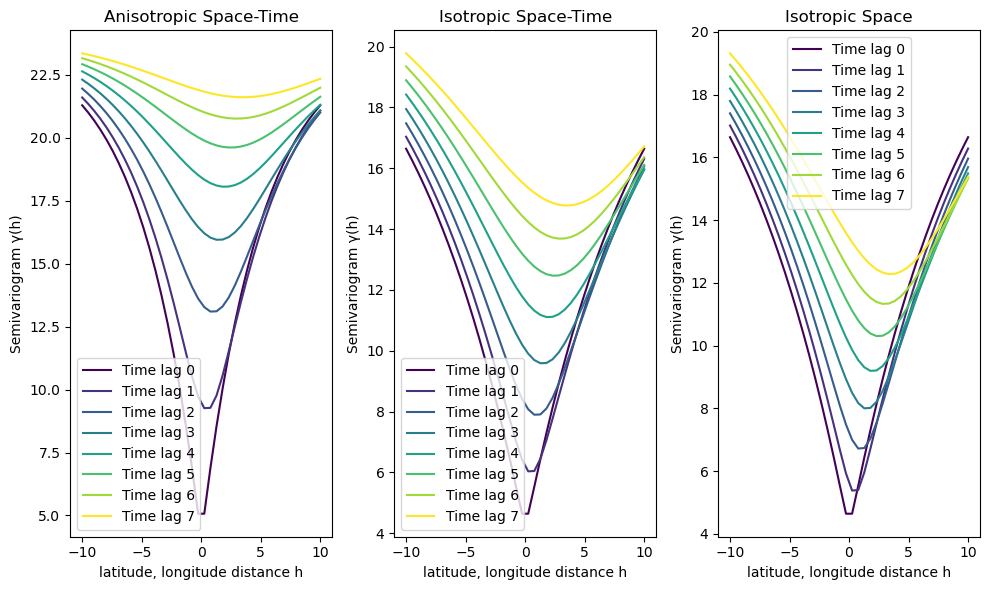

In [21]:
def theoretical_gamma_ani_st(params, lat_diff, lon_diff, time_diff):
    # Unpack parameters
    sigmasq, range_lat, range_lon, advec_lat, advec_lon, beta, nugget = params
    
    # Calculate the spatial-temporal differences
    tmp1 = lat_diff - advec_lat * time_diff
    tmp2 = lon_diff - advec_lon * time_diff
    tmp3 = beta * time_diff
    
    d = tmp1**2/range_lat**2 + tmp2**2/range_lon**2 + tmp3**2
    
    # Convert d into a tensor (if it's not already) and compute the semivariogram
    d = d.clone().detach()

    out = nugget + sigmasq * (1 - torch.exp(- torch.sqrt(d) ) )
    
    return torch.sqrt(d), out

def theoretical_gamma_iso_space(params, lat_diff, lon_diff, time_diff):
    # Unpack parameters
    sigmasq, range_, _, advec_lat, advec_lon, beta, nugget = params
    
    # Calculate the spatial-temporal differences
    tmp1 = lat_diff - advec_lat * time_diff
    tmp2 = lon_diff - advec_lon * time_diff
    tmp3 = beta * time_diff
    
    d = (tmp1**2+ tmp2**2)/range_**2 + tmp3**2
    
    # Convert d into a tensor (if it's not already) and compute the semivariogram
    d = d.clone().detach()

    out = nugget + sigmasq * (1 - torch.exp(- torch.sqrt(d)) )
    
    return torch.sqrt(d), out

def theoretical_gamma_iso_st(params, lat_diff, lon_diff, time_diff):
    # Unpack parameters
    sigmasq, range_, _, advec_lat, advec_lon, _, nugget = params
    
    # Calculate the spatial-temporal differences
    tmp1 = lat_diff - advec_lat * time_diff
    tmp2 = lon_diff - advec_lon * time_diff
    tmp3 = 1 * time_diff
    
    d = tmp1**2+ tmp2**2 + tmp3**2
    
    # Convert d into a tensor (if it's not already) and compute the semivariogram
    d = d.clone().detach()

    out = nugget + sigmasq * (1 - torch.exp(- torch.sqrt(d)/range_ ) )
    
    return torch.sqrt(d), out


def plot_theoretical_semivariogram(params, deltas, time_lags, gamma_fun, ax):
    # Create a plot with different colors for each time difference
    colors = plt.cm.viridis(np.linspace(0, 1, len(time_lags)))  # Color map for different time lags
    
    for t in range(8):
        gamma_values = []
        d_values = []
        for delta in deltas:
            # Calculate theoretical semivariogram for this distance and time lag
            d, gamma = gamma_fun(params, 0.2, delta, time_lags[t])  # lat_diff = lon_diff = delta, time_diff = t
            
            gamma_values.append(gamma.item())  # Convert tensor to scalar for plotting
            d_values.append(d.item())
       
        # Plot the semivariogram for the current time lag
        ax.plot(deltas.numpy(), gamma_values, label=f"Time lag {time_lags[t]}", color=colors[t])
        
    ax.set_xlabel("latitude, longitude distance h")
    ax.set_ylabel("Semivariogram γ(h)")
    ax.legend()

# Example parameters (sigmasq, range, range_lon, advec_lat, advec_lon, beta, nugget)
params = [20, 10, 5, 0.5, 0.5, 0.3, 4]

# Define deltas for distance bins
deltas = torch.linspace(-10,10, 40)

# Define the time lags you want to plot
time_lags = [0,1,2,3,4,5,6,7]

# Create a figure with 3 subplots in one row
fig, axs = plt.subplots(1,3, figsize=(10,6))

# Plot the theoretical semivariogram for the specified time lags in each subplot
plot_theoretical_semivariogram(params, deltas, time_lags, theoretical_gamma_ani_st, axs[0])
axs[0].set_title("Anisotropic Space-Time")

plot_theoretical_semivariogram(params, deltas, time_lags, theoretical_gamma_iso_st, axs[1])
axs[1].set_title("Isotropic Space-Time")


params = [20, 10, 5, 0.5, 0.5, 0.3/5, 4]

plot_theoretical_semivariogram(params, deltas, time_lags, theoretical_gamma_iso_space, axs[2])
axs[2].set_title("Isotropic Space")


plt.tight_layout()
plt.show()


It seems a model isotropic in space but not in time best describe the data

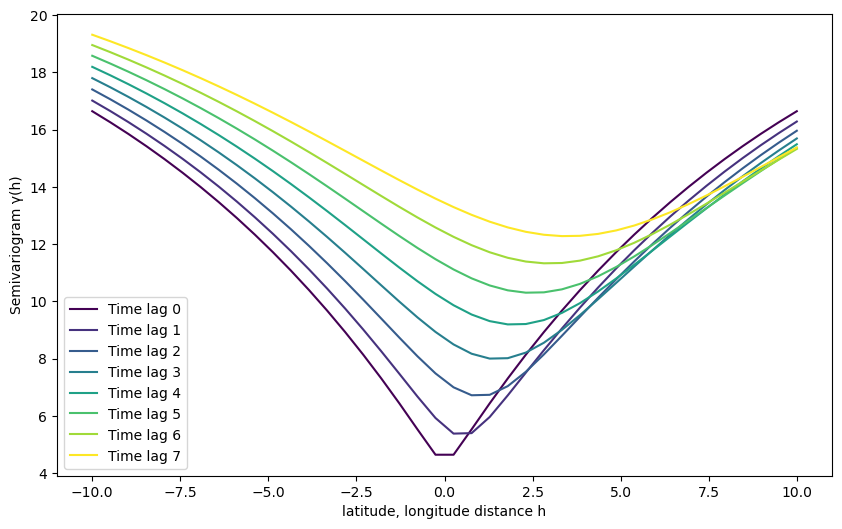

In [23]:

params = [20, 10, 5, 0.5, 0.5, 0.3/5, 4]
# Create a figure with 3 subplots in one row
fig, axs = plt.subplots(1,1, figsize=(10,6))
plot_theoretical_semivariogram(params, deltas, time_lags, theoretical_gamma_iso_space, axs)

time_lags = [1, 2, 3, 4, 5, 6, 7]
deltas = torch.linspace(-10,10, 40)




Empirical semivariogram using simulated data

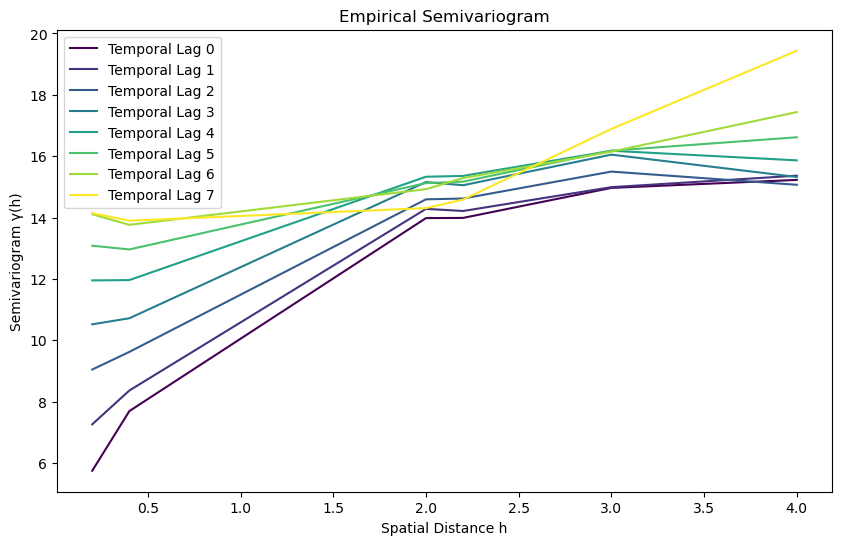

In [42]:
tolerance = 0.01
def empirical_semivariogram(params, data, deltas ,tolerance, latitude_lag,temporal_lag):
    # Extract data columns: latitude, longitude, time, values
    lat = data[:, 0]
    lon = data[:, 1]
    time = data[:, 3]
    values = data[:, 2]  # Assuming the values are in the 3rd column

    # Calculate spatial and temporal distances
    spatial_distances = torch.sqrt((lat.unsqueeze(1) - lat.unsqueeze(0))**2 + (lon.unsqueeze(1) - lon.unsqueeze(0))**2)
    temporal_distances = torch.abs(time.unsqueeze(1) - time.unsqueeze(0))

        # Calculate spatial and temporal distances
    lat_distances = lat.unsqueeze(1) - lat.unsqueeze(0)
    lon_distances = lon.unsqueeze(1) - lon.unsqueeze(0)

    empirical_sem = torch.zeros(len(deltas))
    
    # Calculate the semivariogram for each delta value
    for i in range(len(deltas)):
        # Mask for spatial distances within the delta range and specific temporal lag
        mask = (torch.abs(lat_distances - deltas[i]) <= tolerance) & \
               (torch.abs(lon_distances - deltas[i]) <= tolerance) & \
               (temporal_distances == temporal_lag)
        
        if torch.any(mask):
            # Calculate semivariogram using squared differences of values
            differences = torch.abs(values.unsqueeze(1) - values.unsqueeze(0))
            empirical_sem[i] = 0.5 * torch.mean(differences[mask]**2)

    # Calculate the sill (variance of the values within the given temporal lag)

    
    # Create bins (spatial distances) from the deltas (you can adjust as needed)

    return deltas, empirical_sem

# Define deltas for distance bins
deltas = torch.tensor([0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 1.1, 1.3, 1.7, 2.0, 2.2, 2.5, 3.0, 4.0,5,6,8, 10, 12])
# deltas = torch.linspace(-10,10, 21)
colors = plt.cm.viridis(np.linspace(0, 1, 8))  # Color map for the temporal lags

data = aggregated_np
# Plot the empirical and theoretical semivariogram for different temporal lags
plt.figure(figsize=(10, 6))

latitude_lag = 0.1

for temporal_lag in range(8): 
    deltas, empirical_sem= empirical_semivariogram(params, data, deltas,tolerance, latitude_lag,  temporal_lag)
    
    mask = empirical_sem!=0
    
    deltas_copy = deltas[mask]
    
    tempirical_sem = empirical_sem[mask]
    
    plt.plot( deltas_copy.clone().detach(), tempirical_sem.clone().detach(), color=colors[temporal_lag], label=f'Temporal Lag {temporal_lag}')

plt.xlabel('Spatial Distance h')
plt.ylabel('Semivariogram γ(h)')
plt.title('Empirical Semivariogram')
plt.legend()
plt.show()


Now empirical semivariogram for latitude slice

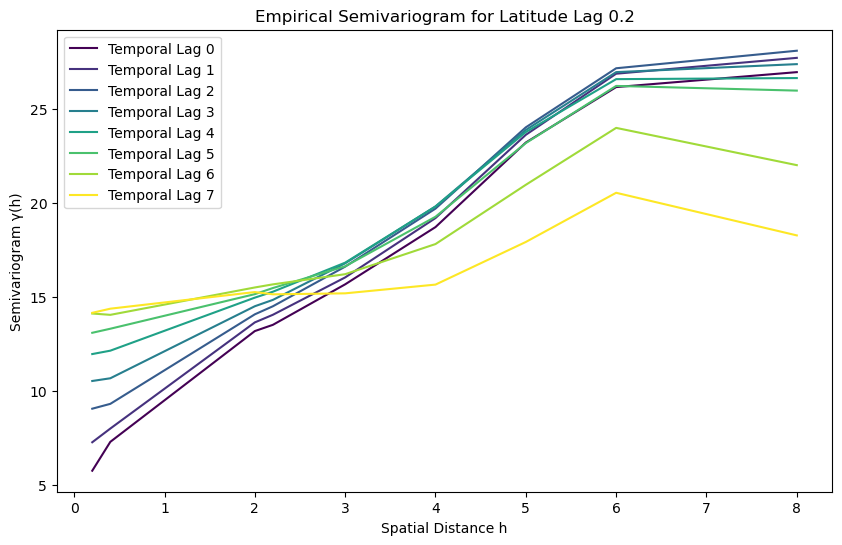

In [41]:
tolerance = 0.02
def empirical_semivariogram_slice(params, data, deltas ,tolerance, latitude_lag,temporal_lag):
    # Extract data columns: latitude, longitude, time, values
    lat = data[:, 0]
    lon = data[:, 1]
    time = data[:, 3]
    values = data[:, 2]  # Assuming the values are in the 3rd column

    # Calculate spatial and temporal distances
    lat_distances = lat.unsqueeze(1) - lat.unsqueeze(0)
    lon_distances = lon.unsqueeze(1) - lon.unsqueeze(0)
    temporal_distances = torch.abs(time.unsqueeze(1) - time.unsqueeze(0))
    
    
    empirical_sem = torch.zeros(len(deltas))
    
    
    # Calculate the semivariogram for each delta value
    for i in range(len(deltas)):
        # Mask for spatial distances within the delta range and specific temporal lag
        mask = (torch.abs(lat_distances - latitude_lag) <= tolerance) & \
               (torch.abs(lon_distances - deltas[i]) <= tolerance) & \
               (temporal_distances == temporal_lag)
        if torch.any(mask):
            # Calculate semivariogram using squared differences of values
            differences = torch.abs(values.unsqueeze(1) - values.unsqueeze(0))
            empirical_sem[i] = 0.5 * torch.mean(differences[mask]**2)

    # Calculate the sill (variance of the values within the given temporal lag)

    
    # Create bins (spatial distances) from the deltas (you can adjust as needed)

    return deltas, empirical_sem

# Define deltas for distance bins
deltas = torch.tensor([0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 1.1, 1.3, 1.7, 2.0, 2.2, 2.5, 3.0, 4.0,5,6,8, 10, 12])

colors = plt.cm.viridis(np.linspace(0, 1, 8))  # Color map for the temporal lags

data = aggregated_np
# Plot the empirical and theoretical semivariogram for different temporal lags
plt.figure(figsize=(10, 6))

latitude_lag = 0.2

for temporal_lag in range(8): 
    deltas, empirical_sem= empirical_semivariogram_slice(params, data, deltas,tolerance, latitude_lag,  temporal_lag)
    mask = empirical_sem!=0
    
    deltas = deltas[mask]
    
    tempirical_sem = empirical_sem[mask]
    
    plt.plot( deltas.clone().detach(), tempirical_sem.clone().detach(), color=colors[temporal_lag], label=f'Temporal Lag {temporal_lag}')

plt.xlabel('Spatial Distance h')
plt.ylabel('Semivariogram γ(h)')
plt.title('Empirical Semivariogram for Latitude Lag 0.2')
plt.legend()
plt.show()

Simulate data and see the empirical semivariogram

In [35]:
params= torch.tensor([20, 8.25, 8.25, 0.2, 0.2, 0.5, 5 ])
# params= torch.tensor([20, 8.25,8.25, 0.2 , 0.2, 1, 5 ])

# Define the Matern covariance function

def matern_cov_iso_st(params: torch.Tensor, y: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    sigmasq, range_, range_lon, advec_lat, advec_lon, _, nugget = params
    
    if y is None or x is None:
        raise ValueError("Both y and x_df must be provided.")

    x1 = x[:, 0]
    y1 = x[:, 1]
    t1 = x[:, 3]

    x2 = y[:, 0]
    y2 = y[:, 1]
    t2 = y[:, 3]

    spat_coord1 = torch.stack(( (x1 - advec_lat * t1), (y1 - advec_lon * t1)), dim=-1)
    spat_coord2 = torch.stack(( (x2 - advec_lat * t2), (y2 - advec_lon * t2)), dim=-1)

    coords1 = torch.cat((spat_coord1, (1 * t1).reshape(-1, 1)), dim=1)
    coords2 = torch.cat((spat_coord2, (1 * t2).reshape(-1, 1)), dim=1)

    U = coords1
    V = coords2 
 
    diff = U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0)
    spatial_diff = torch.norm(diff, dim=2)
    temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
    distance = ( spatial_diff**2 + temporal_diff**2 )

    out = torch.zeros_like(distance)

    non_zero_indices = distance != 0
    if torch.any(non_zero_indices):
        out[non_zero_indices] = sigmasq * torch.exp(- torch.sqrt(distance[non_zero_indices])/range_)
    out[~non_zero_indices] = sigmasq

    # Add a small jitter term to the diagonal for numerical stability
    out += torch.eye(out.shape[0]) * nugget

    return out

# iso in space but not in time
def matern_cov_iso_space(params: torch.Tensor, y: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    sigmasq, range1, range2, advec_lat, advec_lon, beta, nugget = params
    
    if y is None or x is None:
        raise ValueError("Both y and x_df must be provided.")

    x1 = x[:, 0]
    y1 = x[:, 1]
    t1 = x[:, 3]

    x2 = y[:, 0]
    y2 = y[:, 1]
    t2 = y[:, 3]

    spat_coord1 = torch.stack(( (x1 - advec_lat * t1), (y1 - advec_lon * t1)), dim=-1)
    spat_coord2 = torch.stack(( (x2 - advec_lat * t2), (y2 - advec_lon * t2)), dim=-1)

    coords1 = torch.cat((spat_coord1, (beta * t1).reshape(-1, 1)), dim=1)
    coords2 = torch.cat((spat_coord2, (beta * t2).reshape(-1, 1)), dim=1)

    U = coords1
    V = coords2 
 
    diff = U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0)
    spatial_diff = torch.norm(diff, dim=2)
    temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
    distance = (spatial_diff**2/range1**2 + temporal_diff**2)

    out = torch.zeros_like(distance)

    non_zero_indices = distance != 0
    if torch.any(non_zero_indices):
        out[non_zero_indices] = sigmasq * torch.exp(- torch.sqrt(distance[non_zero_indices]))
    out[~non_zero_indices] = sigmasq

    # Add a small jitter term to the diagonal for numerical stability
    out += torch.eye(out.shape[0]) * nugget

    return out

# anisotropic in three 
def matern_cov_ani(params: torch.Tensor, y: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    sigmasq, range_lat, range_lon, advec_lat, advec_lon, beta, nugget = params
    
    if y is None or x is None:
        raise ValueError("Both y and x_df must be provided.")

    x1 = x[:, 0]
    y1 = x[:, 1]
    t1 = x[:, 3]

    x2 = y[:, 0]
    y2 = y[:, 1]
    t2 = y[:, 3]

    spat_coord1 = torch.stack(( (x1 - advec_lat * t1)/range_lat, (y1 - advec_lon * t1)/range_lon), dim=-1)
    spat_coord2 = torch.stack(( (x2 - advec_lat * t2)/range_lat, (y2 - advec_lon * t2)/range_lon), dim=-1)

    coords1 = torch.cat((spat_coord1, (beta * t1).reshape(-1, 1)), dim=1)
    coords2 = torch.cat((spat_coord2, (beta * t2).reshape(-1, 1)), dim=1)

    U = coords1
    V = coords2 
 
    diff = U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0)
    spatial_diff = torch.norm(diff, dim=2)
    temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
    distance = (spatial_diff**2 + temporal_diff**2)

    out = torch.zeros_like(distance)

    non_zero_indices = distance != 0
    if torch.any(non_zero_indices):
        out[non_zero_indices] = sigmasq * torch.exp(- torch.sqrt(distance[non_zero_indices]))
    out[~non_zero_indices] = sigmasq

    # Add a small jitter term to the diagonal for numerical stability
    out += torch.eye(out.shape[0]) * nugget

    return out

# Generate random data for testing
def generate_data(size, params, cov_function):

    # Generate random coordinates and time values
    latitudes = torch.linspace(5, 10, size)
    longitudes = torch.randint(110, 121, (size,))
    
    times = torch.randint(1, 9, (size,))
    
    x = torch.stack((latitudes, longitudes, latitudes, times), dim=1)
    
    # Simulate ozone values using the covariance function
    cov_matrix = cov_function(params, x, x)
    
    # Generate ozone values from a multivariate normal distribution with the covariance matrix
    ozone_values = torch.distributions.MultivariateNormal(torch.zeros(size), cov_matrix).sample()
    
    # Scale ozone values to be between 250 and 350

    data = torch.cat((latitudes.unsqueeze(1), longitudes.unsqueeze(1),  ozone_values.unsqueeze(1), times.unsqueeze(1) ), dim=1)
    
    return data

# Generate data with size 1000
data_ani = generate_data(20000, params, matern_cov_ani)
data_iso_st = generate_data(20000, params, matern_cov_iso_st)


params = [20, 10, 5, 0.5, 0.5, 0.3/5, 4]
data_iso_space = generate_data(20000, params, matern_cov_iso_space)




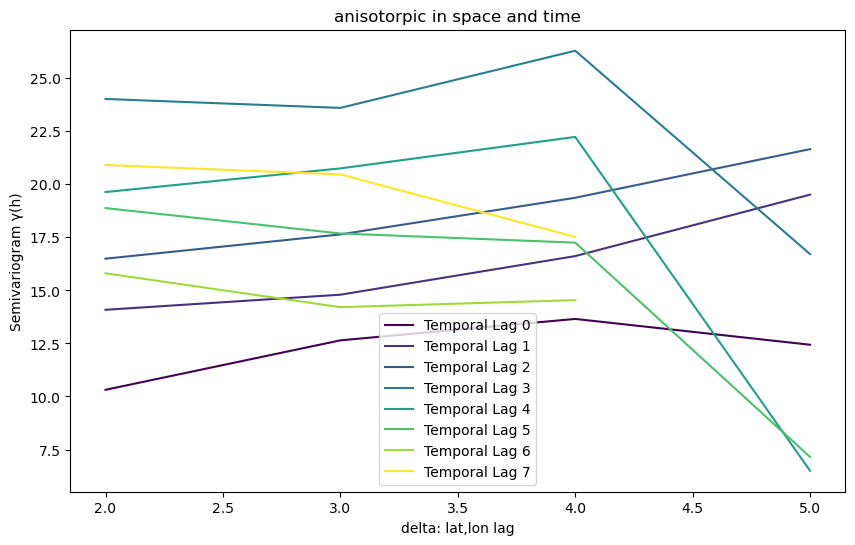

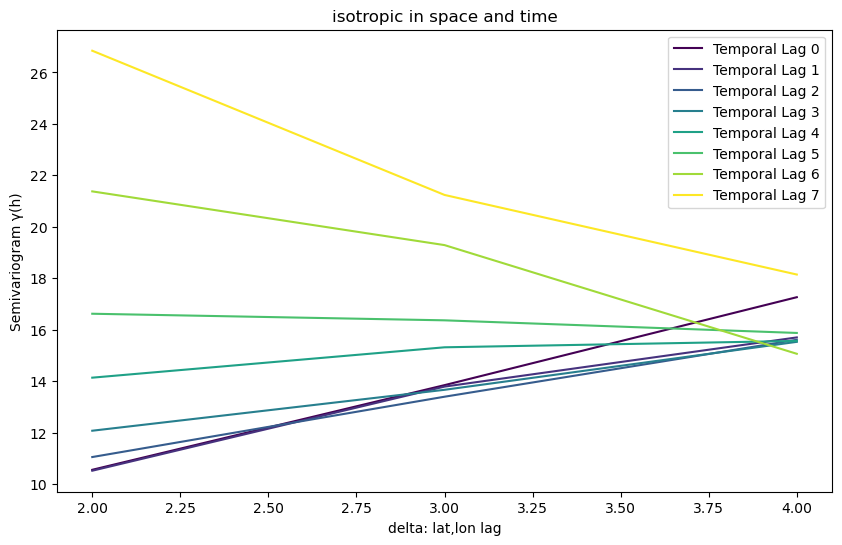

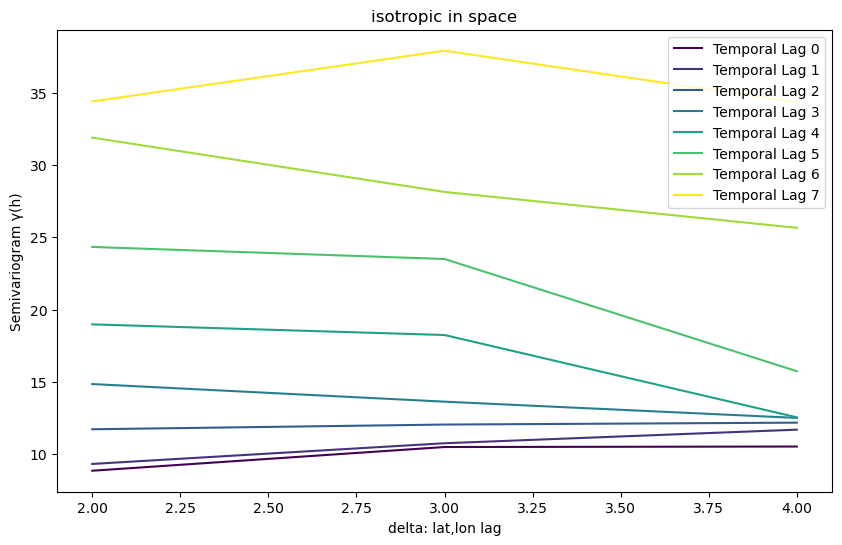

In [ ]:
params= torch.tensor( [20, 8.25,8.25, 0.2 , 0.2, 0.5, 5 ]  )

tolerance = 0.01
# Define deltas for distance bins
deltas = torch.tensor([0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 1.1, 1.3, 1.7, 2.0, 2.2, 2.5, 3.0, 4.0,5,6,8, 10, 12])
# deltas = torch.linspace(-10,10, 21)

colors = plt.cm.viridis(np.linspace(0, 1, 8))  # Color map for the temporal lags

# Plot the empirical and theoretical semivariogram for different temporal lags
plt.figure(figsize=(10, 6))

latitude_lag = 0.2

for temporal_lag in range(8): 
    deltas, emp_gamma = empirical_semivariogram(params, data_ani, deltas,tolerance, latitude_lag,  temporal_lag)
    mask = emp_gamma!=0
    deltas = deltas[mask]
    emp_gamma = emp_gamma[mask]
    
    plt.plot( deltas.clone().detach(), emp_gamma.clone().detach(), color=colors[temporal_lag], label=f'Temporal Lag {temporal_lag}')

plt.xlabel('delta: lat,lon lag')
plt.ylabel('Semivariogram γ(h)')
plt.title('anisotorpic in space and time')
plt.legend()
plt.show()



plt.figure(figsize=(10, 6))
for temporal_lag in range(8): 
    deltas, emp_gamma = empirical_semivariogram(params, data_iso_st, deltas,tolerance, latitude_lag,  temporal_lag)
    mask = emp_gamma!=0
    deltas = deltas[mask]
    emp_gamma = emp_gamma[mask]
    
    plt.plot( deltas.clone().detach(), emp_gamma.clone().detach(), color=colors[temporal_lag], label=f'Temporal Lag {temporal_lag}')

plt.xlabel('delta: lat,lon lag')
plt.ylabel('Semivariogram γ(h)')
plt.title('isotropic in space and time')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
params= torch.tensor( [20, 10, 5, 0.5, 0.5, 0.3/5, 4] )

for temporal_lag in range(8): 
    deltas, emp_gamma = empirical_semivariogram(params, data_iso_space, deltas,tolerance, latitude_lag,  temporal_lag)
    mask = emp_gamma!=0
    deltas = deltas[mask]
    emp_gamma = emp_gamma[mask]
    
    plt.plot( deltas.clone().detach(), emp_gamma.clone().detach(), color=colors[temporal_lag], label=f'Temporal Lag {temporal_lag}')

plt.xlabel('delta: lat,lon lag' )
plt.ylabel('Semivariogram γ(h)')
plt.title('isotropic in space')
plt.legend()
plt.show()

how about latitude slice

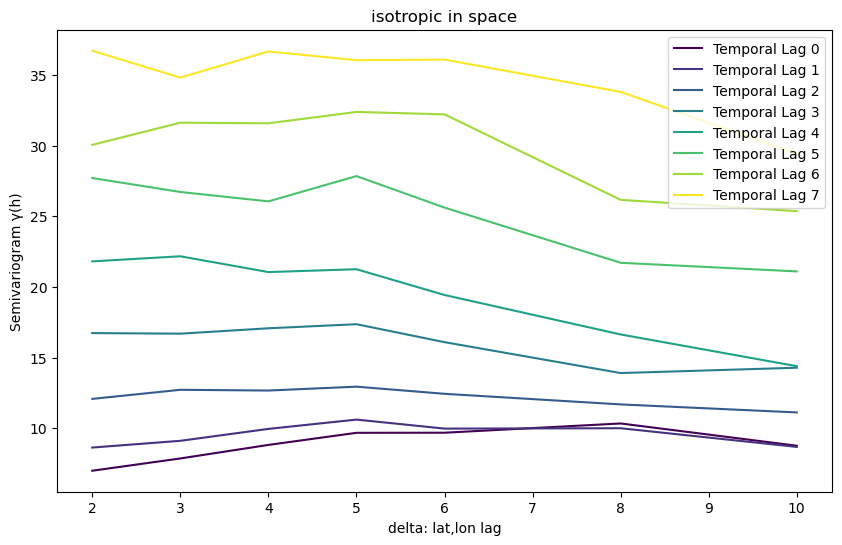

In [43]:
plt.figure(figsize=(10, 6))

latitude_lag = 0.2

for temporal_lag in range(8): 
    deltas, empirical_sem= empirical_semivariogram_slice(params, data_iso_space, deltas,tolerance, latitude_lag,  temporal_lag)
    mask = empirical_sem!=0
    
    deltas = deltas[mask]
    
    tempirical_sem = empirical_sem[mask]
    
    plt.plot( deltas.clone().detach(), tempirical_sem.clone().detach(), color=colors[temporal_lag], label=f'Temporal Lag {temporal_lag}')

plt.xlabel('delta: lat,lon lag' )
plt.ylabel('Semivariogram γ(h)')
plt.title('isotropic in space')
plt.legend()
plt.show()

Simulate isotropic in space model 4 times

params= torch.tensor( [20, 10, 5, 0.5, 0.5, 0.3/5, 4] )

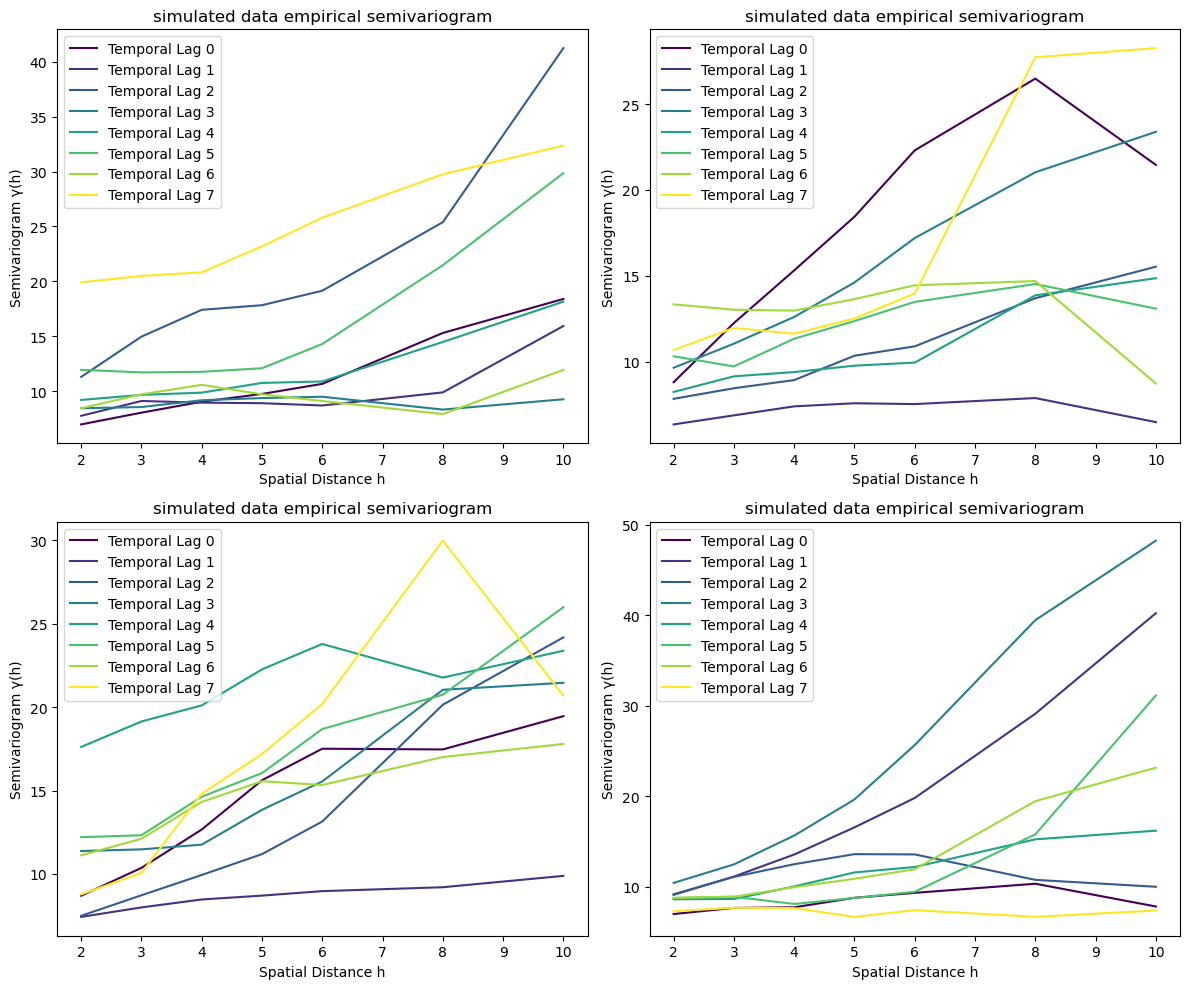

In [45]:
params= torch.tensor( [20, 10, 5, 0.5, 0.5, 0.3/5, 4] )

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
deltas = torch.tensor([0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 1.1, 1.3, 1.7, 2.0, 2.2, 2.5, 3.0, 4.0,5,6,8, 10, 12])

# Iterate over the list of parameter sets
for idx in range(4):
    ax = axs[idx // 2, idx % 2]
    for temporal_lag in range(8):
        data_iso_space = generate_data(10000, params, matern_cov_iso_space)
        deltas, emp_gamma = empirical_semivariogram_slice(params, data_iso_space, deltas, tolerance, latitude_lag, temporal_lag)
        mask = emp_gamma != 0
        deltas = deltas[mask]
        emp_gamma = emp_gamma[mask]
        
        ax.plot(deltas.clone().detach(), emp_gamma.clone().detach(), color=colors[temporal_lag], label=f'Temporal Lag {temporal_lag}')
    
    ax.set_xlabel('Spatial Distance h')
    ax.set_ylabel('Semivariogram γ(h)')
    ax.set_title(f'simulated data empirical semivariogram')
    ax.legend()

plt.tight_layout()
plt.show()

day2 codes have to be reviewed from this part

/var/folders/9p/53hd4c7d2fl193h4jwp194wc0000gn/T/ipykernel_816/3668564536.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(aggregated_np)  # Assuming `your_data` is a Numpy array
/var/folders/9p/53hd4c7d2fl193h4jwp194wc0000gn/T/ipykernel_816/1637770891.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lat = torch.tensor(lat)
/var/folders/9p/53hd4c7d2fl193h4jwp194wc0000gn/T/ipykernel_816/1637770891.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lon = torch.tensor(lon)
/var/folders/9p/53hd4c7d2fl193h4jwp194wc

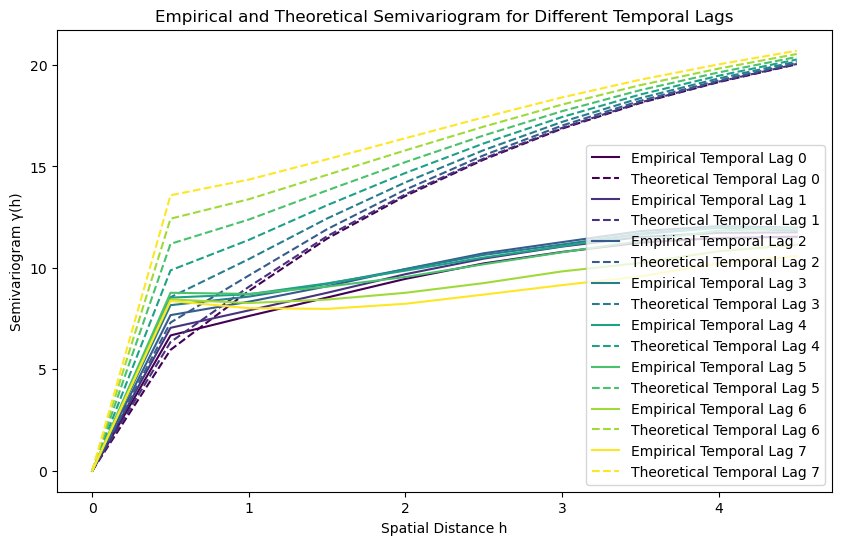

In [69]:

key_for_dict= [8, 16]
analysis_data_map = {}
for i in range(key_for_dict[0],key_for_dict[1]):
    tmp = coarse_dicts[key_idx[i]].copy()
    tmp['Hours_elapsed'] = np.round(tmp['Hours_elapsed']-477700)

    tmp = tmp.iloc[ord_mm, :4].to_numpy()
    tmp = torch.from_numpy(tmp).float()  # Convert NumPy to Tensor
    # tmp = tmp.clone().detach().requires_grad_(True)  # Enable gradients
    
    analysis_data_map[key_idx[i]] = tmp

aggregated_data = pd.DataFrame()
for i in range(key_for_dict[0],key_for_dict[1]):
    tmp = coarse_dicts[key_idx[i]].copy()
    tmp['Hours_elapsed'] = np.round(tmp['Hours_elapsed']-477700)
    tmp = tmp.iloc[ord_mm].reset_index(drop=True)  
    aggregated_data = pd.concat((aggregated_data, tmp), axis=0)

aggregated_np = aggregated_data.iloc[:, :4].to_numpy()

aggregated_np = torch.from_numpy(aggregated_np).float()  # Convert NumPy to Tensor
# aggregated_np = aggregated_np.clone().detach().requires_grad_(True)  # Enable gradients


instance = kernels.likelihood_function(smooth=0.5, input_map=analysis_data_map, nns_map=nns_map, mm_cond_number=mm_cond_number)


# Example usage
# Replace `your_data` with your actual data
data = torch.tensor(aggregated_np)  # Assuming `your_data` is a Numpy array
max_distance = 5
num_bins = 10

# Define parameters for the theoretical semivariogram
# params = torch.tensor([24.42, 1.92, 1.92, -0.045, 0.237, 3.34])  # Example parameters: sigmasq, range, range_lon, advec, beta, nugget
params = torch.tensor([23.59, 3.83, 3.83, 0.036, 0.277, 2.83  ]) 
params = torch.tensor([24.56, 2.80, 2.80, -0.0138, .301, 2.12  ]) 

# Plot the empirical and theoretical semivariogram for different temporal lags
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, 8))  # Generate a color map

for temporal_lag in range(8):
    bins, empirical_gamma = empirical_semivariogram(data, max_distance, num_bins, temporal_lag)
    bins, theoretical_gamma = theoretical_semivariogram(params, data, max_distance, num_bins, temporal_lag)
    
    plt.plot(bins.numpy(), empirical_gamma.numpy(), '-', color=colors[temporal_lag], label=f'Empirical Temporal Lag {temporal_lag}')
    plt.plot(bins.numpy(), theoretical_gamma.numpy(), '--', color=colors[temporal_lag], label=f'Theoretical Temporal Lag {temporal_lag}')

plt.xlabel('Spatial Distance h')
plt.ylabel('Semivariogram γ(h)')
plt.title('Empirical and Theoretical Semivariogram for Different Temporal Lags')
plt.legend()
plt.show()

day3 

/var/folders/9p/53hd4c7d2fl193h4jwp194wc0000gn/T/ipykernel_816/4198474054.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(aggregated_np)  # Assuming `your_data` is a Numpy array
/var/folders/9p/53hd4c7d2fl193h4jwp194wc0000gn/T/ipykernel_816/2603726844.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lat = torch.tensor(lat)
/var/folders/9p/53hd4c7d2fl193h4jwp194wc0000gn/T/ipykernel_816/2603726844.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lon = torch.tensor(lon)
/var/folders/9p/53hd4c7d2fl193h4jwp194wc

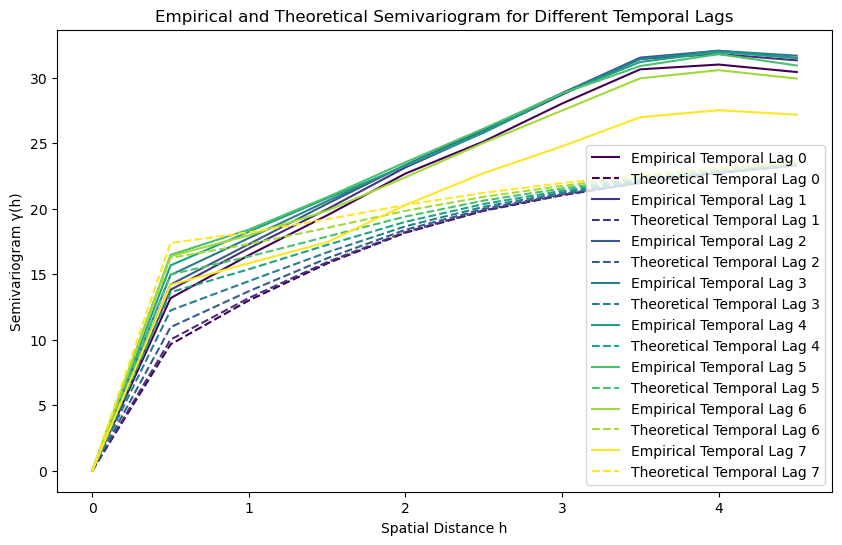

In [65]:
key_for_dict= [16, 24]
analysis_data_map = {}
for i in range(key_for_dict[0],key_for_dict[1]):
    tmp = coarse_dicts[key_idx[i]].copy()
    tmp['Hours_elapsed'] = np.round(tmp['Hours_elapsed']-477700)

    tmp = tmp.iloc[ord_mm, :4].to_numpy()
    tmp = torch.from_numpy(tmp).float()  # Convert NumPy to Tensor
    # tmp = tmp.clone().detach().requires_grad_(True)  # Enable gradients
    
    analysis_data_map[key_idx[i]] = tmp

aggregated_data = pd.DataFrame()
for i in range(key_for_dict[0],key_for_dict[1]):
    tmp = coarse_dicts[key_idx[i]].copy()
    tmp['Hours_elapsed'] = np.round(tmp['Hours_elapsed']-477700)
    tmp = tmp.iloc[ord_mm].reset_index(drop=True)  
    aggregated_data = pd.concat((aggregated_data, tmp), axis=0)

aggregated_np = aggregated_data.iloc[:, :4].to_numpy()

aggregated_np = torch.from_numpy(aggregated_np).float()  # Convert NumPy to Tensor
# aggregated_np = aggregated_np.clone().detach().requires_grad_(True)  # Enable gradients


instance = kernels.likelihood_function(smooth=0.5, input_map=analysis_data_map, nns_map=nns_map, mm_cond_number=mm_cond_number)


# Example usage
# Replace `your_data` with your actual data
data = torch.tensor(aggregated_np)  # Assuming `your_data` is a Numpy array
max_distance = 5
num_bins = 10

# Define parameters for the theoretical semivariogram
# params = torch.tensor([24.42, 1.92, 1.92, -0.045, 0.237, 3.34])  # Example parameters: sigmasq, range, range_lon, advec, beta, nugget
# params = torch.tensor([23.59, 3.83, 3.83, 0.036, 0.277, 2.83  ]) 
params = torch.tensor([24.91, 1.73, 1.73, -0.056, .259, 3.57 ]) 

# Plot the empirical and theoretical semivariogram for different temporal lags
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, 8))  # Generate a color map

for temporal_lag in range(8):
    bins, empirical_gamma = empirical_semivariogram(data, max_distance, num_bins, temporal_lag)
    bins, theoretical_gamma = theoretical_semivariogram(params, data, max_distance, num_bins, temporal_lag)
    
    plt.plot(bins.numpy(), empirical_gamma.numpy(), '-', color=colors[temporal_lag], label=f'Empirical Temporal Lag {temporal_lag}')
    plt.plot(bins.numpy(), theoretical_gamma.numpy(), '--', color=colors[temporal_lag], label=f'Theoretical Temporal Lag {temporal_lag}')

plt.xlabel('Spatial Distance h')
plt.ylabel('Semivariogram γ(h)')
plt.title('Empirical and Theoretical Semivariogram for Different Temporal Lags')
plt.legend()
plt.show()